# PhysioNet Channel Selection Method Comparison

Compare channel selection performance of EEG-ARNN against standard baselines:
- **EEG-ARNN (Ours)**: CARM-based channel selection using learned adjacency matrix
- **EEGNet**: Gradient-based channel importance
- **FBCNet**: Spatial filter weights
- **CSP**: Classical Common Spatial Patterns channel ranking
- **Mutual Information**: Statistical channel-label dependency

**Evaluation Metric**: Accuracy after retraining with top-k selected channels
**Goal**: Which method selects the most informative channels that maintain/improve accuracy with fewer channels?

All methods tested on the same 5 subjects with 2-fold CV.

## Setup and Imports

In [34]:
import sys
from pathlib import Path
import warnings
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import mne
from mne.decoding import CSP

from models import EEGARNN
from train_utils import load_preprocessed_data, filter_classes, EEGDataset

warnings.filterwarnings('ignore')
mne.set_log_level('ERROR')
sns.set_context('notebook', font_scale=1.1)
plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


## Configuration

In [35]:
CONFIG = {
    'data': {
        'preprocessed_dir': Path('data/physionet/derived/preprocessed'),
        'index_file': Path('data/physionet/derived/physionet_preprocessed_index.csv'),
        'selected_classes': [1, 2],  # Binary classification
        'tmin': -1.0,
        'tmax': 5.0,
        'baseline': (-0.5, 0)
    },
    'training': {
        'epochs': 30,
        'learning_rate': 0.001,
        'batch_size': 32,
        'n_folds': 2,
        'patience': 8
    },
    'channel_selection': {
        'k_values': [10, 15, 20, 25],  # Match EEG-ARNN k values
        'selection_method': 'aggregation'
    },
    'subjects': ['S001', 'S002', 'S005', 'S006', 'S007'],
    'output_dir': Path('results/channel_selection_comparison')
}

CONFIG['output_dir'].mkdir(parents=True, exist_ok=True)
print(json.dumps(CONFIG, indent=2, default=str))

{
  "data": {
    "preprocessed_dir": "data\\physionet\\derived\\preprocessed",
    "index_file": "data\\physionet\\derived\\physionet_preprocessed_index.csv",
    "selected_classes": [
      1,
      2
    ],
    "tmin": -1.0,
    "tmax": 5.0,
    "baseline": [
      -0.5,
      0
    ]
  },
  "training": {
    "epochs": 30,
    "learning_rate": 0.001,
    "batch_size": 32,
    "n_folds": 2,
    "patience": 8
  },
  "channel_selection": {
    "k_values": [
      10,
      15,
      20,
      25
    ],
    "selection_method": "aggregation"
  },
  "subjects": [
    "S001",
    "S002",
    "S005",
    "S006",
    "S007"
  ],
  "output_dir": "results\\channel_selection_comparison"
}


## Baseline Model Implementations

### 1. EEGNet (Lawhern et al., 2018)

In [36]:
class EEGNet(nn.Module):
    """
    EEGNet: A Compact Convolutional Neural Network for EEG-based Brain-Computer Interfaces
    Reference: Lawhern et al., 2018
    """
    def __init__(self, num_channels=64, num_timepoints=769, num_classes=2, 
                 F1=8, D=2, F2=16, dropout=0.5):
        super(EEGNet, self).__init__()
        
        self.num_channels = num_channels
        self.num_timepoints = num_timepoints
        self.F1 = F1
        self.D = D
        self.F2 = F2
        
        # Block 1: Temporal convolution
        self.conv1 = nn.Conv2d(1, F1, (1, 64), padding=(0, 32), bias=False)
        self.bn1 = nn.BatchNorm2d(F1)
        
        # Block 2: Depthwise convolution (spatial filter)
        self.conv2 = nn.Conv2d(F1, F1*D, (num_channels, 1), groups=F1, bias=False)
        self.bn2 = nn.BatchNorm2d(F1*D)
        self.activation = nn.ELU()
        self.pool1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout)
        
        # Block 3: Separable convolution
        self.conv3 = nn.Conv2d(F1*D, F1*D, (1, 16), padding=(0, 8), groups=F1*D, bias=False)
        self.conv4 = nn.Conv2d(F1*D, F2, (1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(F2)
        self.pool2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout)
        
        # Calculate flattened size
        self.flatten_size = self._get_flatten_size()
        
        # Fully connected layer
        self.fc = nn.Linear(self.flatten_size, num_classes)
        
    def _get_flatten_size(self):
        """Calculate the size after convolutions and pooling"""
        with torch.no_grad():
            x = torch.zeros(1, 1, self.num_channels, self.num_timepoints)
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.pool1(x)
            x = self.conv3(x)
            x = self.conv4(x)
            x = self.pool2(x)
            return x.numel()
    
    def forward(self, x):
        # Input: (batch, 1, channels, timepoints) - already has channel dim from EEGDataset
        
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        
        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 3
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.bn3(x)
        x = self.activation(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Flatten and classify
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

### 2. FBCNet (Mane et al., 2021)

In [37]:
class FBCNet(nn.Module):
    """
    FBCNet: Filter Bank Convolutional Network
    Reference: Mane et al., 2021 (Winner of BCI Competition)
    Simplified version for comparison
    """
    def __init__(self, num_channels=64, num_timepoints=769, num_classes=2, 
                 num_filters=9, dropout=0.5):
        super(FBCNet, self).__init__()
        
        self.num_channels = num_channels
        self.num_timepoints = num_timepoints
        self.num_filters = num_filters
        
        # Spatial convolution (learns spatial filters like CSP)
        self.spatial_conv = nn.Conv2d(1, num_filters, (num_channels, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(num_filters)
        
        # Temporal convolution
        self.temporal_conv = nn.Conv2d(num_filters, num_filters*2, (1, 32), 
                                       padding=(0, 16), bias=False)
        self.bn2 = nn.BatchNorm2d(num_filters*2)
        self.activation = nn.ELU()
        self.pool = nn.AvgPool2d((1, 8))
        self.dropout = nn.Dropout(dropout)
        
        # Calculate flattened size
        self.flatten_size = self._get_flatten_size()
        
        # Classifier
        self.fc = nn.Linear(self.flatten_size, num_classes)
        
    def _get_flatten_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, self.num_channels, self.num_timepoints)
            x = self.spatial_conv(x)
            x = self.temporal_conv(x)
            x = self.pool(x)
            return x.numel()
    
    def forward(self, x):
        # Input: (batch, 1, channels, timepoints) - already has channel dim from EEGDataset
        
        # Spatial filtering
        x = self.spatial_conv(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        # Temporal filtering
        x = self.temporal_conv(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.pool(x)
        x = self.dropout(x)
        
        # Classify
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

### 3. Pure CNN (Ablation Study)

In [38]:
class PureCNN(nn.Module):
    """
    Deep CNN without graph convolution (ablation study)
    Same architecture as EEG-ARNN but replaces CARM layers with standard CNN
    """
    def __init__(self, num_channels=64, num_timepoints=769, num_classes=2, hidden_dim=40):
        super(PureCNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # Block 1: CNN
        self.conv1 = nn.Conv2d(1, hidden_dim, (1, 5), padding=(0, 2))
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        
        # Block 2: CNN
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, (1, 5), padding=(0, 2))
        self.bn2 = nn.BatchNorm2d(hidden_dim)
        
        # Block 3: CNN
        self.conv3 = nn.Conv2d(hidden_dim, hidden_dim, (1, 5), padding=(0, 2))
        self.bn3 = nn.BatchNorm2d(hidden_dim)
        
        self.activation = nn.ELU()
        self.pool = nn.AdaptiveAvgPool2d((num_channels, 1))
        
        # Classifier
        self.fc = nn.Linear(hidden_dim * num_channels, num_classes)
        
    def forward(self, x):
        # Input: (batch, 1, channels, timepoints) - already has channel dim from EEGDataset
        
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)
        
        # Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.activation(x)
        
        # Pool and classify
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

## Channel Selection Strategies

In [39]:
from sklearn.feature_selection import mutual_info_classif
from models import ChannelSelector

def select_channels_csp(X_train, y_train, k):
    """
    CSP-based channel selection
    Rank channels by their contribution to CSP patterns
    """
    csp = CSP(n_components=4, reg=None, log=False, norm_trace=False)
    csp.fit(X_train, y_train)
    
    # CSP patterns shape: (n_components, n_channels)
    # Rank channels by sum of absolute pattern weights
    channel_importance = np.sum(np.abs(csp.patterns_), axis=0)
    selected_indices = np.argsort(channel_importance)[-k:]
    selected_indices = np.sort(selected_indices)
    
    return selected_indices


def select_channels_mutual_info(X_train, y_train, k):
    """
    Mutual Information-based channel selection
    Select channels with highest mutual information with labels
    """
    n_trials, n_channels, n_timepoints = X_train.shape
    
    # Average over time to get (n_trials, n_channels)
    X_avg = np.mean(X_train, axis=2)
    
    # Compute mutual information
    mi_scores = mutual_info_classif(X_avg, y_train, random_state=42)
    
    selected_indices = np.argsort(mi_scores)[-k:]
    selected_indices = np.sort(selected_indices)
    
    return selected_indices


def select_channels_gradient(model, data_loader, device, k):
    """
    Gradient-based channel importance for CNN models (EEGNet, FBCNet, Pure CNN)
    Use gradients of loss w.r.t. channel activations
    """
    model.eval()
    channel_gradients = None
    
    for batch_data, batch_labels in data_loader:
        batch_data = batch_data.to(device).float()
        batch_labels = batch_labels.to(device).long()
        batch_data.requires_grad = True
        
        outputs = model(batch_data)
        loss = F.cross_entropy(outputs, batch_labels)
        loss.backward()
        
        # Sum gradients across batch and time
        # batch_data shape: (batch, 1, channels, time)
        grads = torch.abs(batch_data.grad).sum(dim=(0, 1, 3))  # (channels,)
        
        if channel_gradients is None:
            channel_gradients = grads.detach().cpu().numpy()
        else:
            channel_gradients += grads.detach().cpu().numpy()
        
        batch_data.requires_grad = False
    
    selected_indices = np.argsort(channel_gradients)[-k:]
    selected_indices = np.sort(selected_indices)
    
    return selected_indices


def select_channels_eegarnn(model, k, method='aggregation'):
    """
    EEG-ARNN channel selection using learned adjacency matrix
    """
    adj_matrix = model.get_final_adjacency_matrix()
    
    # Dummy channel names
    channel_names = [f'Ch{i}' for i in range(adj_matrix.shape[0])]
    selector = ChannelSelector(adj_matrix, channel_names)
    
    if method == 'edge':
        _, selected_indices = selector.edge_selection(k=k)
    else:  # aggregation
        _, selected_indices = selector.aggregation_selection(k=k)
    
    return selected_indices, adj_matrix


def select_channels_spatial_weights(model, k):
    """
    Select channels based on spatial convolution weights (for FBCNet/EEGNet)
    """
    # Get first spatial convolution layer weights
    if hasattr(model, 'conv2'):  # EEGNet
        weights = model.conv2.weight.data.cpu().numpy()  # (F1*D, F1, channels, 1)
        weights = np.abs(weights).sum(axis=(0, 1, 3))  # (channels,)
    elif hasattr(model, 'spatial_conv'):  # FBCNet
        weights = model.spatial_conv.weight.data.cpu().numpy()  # (filters, 1, channels, 1)
        weights = np.abs(weights).sum(axis=(0, 1, 3))  # (channels,)
    else:
        raise ValueError("Model doesn't have spatial convolution layer")
    
    selected_indices = np.argsort(weights)[-k:]
    selected_indices = np.sort(selected_indices)
    
    return selected_indices


def select_channels_pure_cnn(model, data_loader, device, k):
    """
    Pure CNN channel selection using gradient-based importance
    Since Pure CNN has no spatial convolution, use gradient method
    """
    return select_channels_gradient(model, data_loader, device, k)

## Channel Selection Evaluation Pipeline

In [40]:
def train_deep_model(model, train_loader, val_loader, epochs, lr, device, patience=8):
    """
    Generic training function for PyTorch models with early stopping
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=False
    )
    
    best_val_acc = 0.0
    best_epoch = 0
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        for batch_data, batch_labels in train_loader:
            batch_data = batch_data.to(device).float()
            batch_labels = batch_labels.to(device).long()
            
            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_data, batch_labels in val_loader:
                batch_data = batch_data.to(device).float()
                batch_labels = batch_labels.to(device).long()
                
                outputs = model(batch_data)
                _, predicted = torch.max(outputs, 1)
                
                val_total += batch_labels.size(0)
                val_correct += (predicted == batch_labels).sum().item()
        
        val_acc = val_correct / val_total
        scheduler.step(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            break
    
    return best_val_acc, best_epoch


def evaluate_channel_selection(method_name, model_class, data, labels, config, device):
    """
    Evaluate channel selection method
    """
    import time
    from train_utils import normalize_data
    
    n_folds = config['training']['n_folds']
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    results = {k: {'accuracies': [], 'selected_channels': []} for k in config['channel_selection']['k_values']}
    results['all_channels'] = {'accuracies': []}
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(data, labels), 1):
        X_train, X_val = data[train_idx], data[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        X_train_norm = normalize_data(X_train)
        X_val_norm = normalize_data(X_val)
        
        num_channels = data.shape[1]
        num_timepoints = data.shape[2]
        num_classes = len(np.unique(labels))
        
        # Step 1: Train on ALL channels
        if method_name == 'CSP':
            csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
            svm = SVC(kernel='rbf', C=1.0, gamma='scale')
            X_train_csp = csp.fit_transform(X_train, y_train)
            X_val_csp = csp.transform(X_val)
            svm.fit(X_train_csp, y_train)
            all_channels_acc = svm.score(X_val_csp, y_val)
        elif method_name == 'Mutual':
            model = EEGNet(num_channels, num_timepoints, num_classes).to(device)
            train_dataset = EEGDataset(X_train_norm, y_train)
            val_dataset = EEGDataset(X_val_norm, y_val)
            train_loader = DataLoader(train_dataset, batch_size=config['training']['batch_size'], shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=config['training']['batch_size'], shuffle=False)
            all_channels_acc, _ = train_deep_model(model, train_loader, val_loader,
                                                    config['training']['epochs'],
                                                    config['training']['learning_rate'],
                                                    device, config['training']['patience'])
        else:
            # Deep learning: EEGNet, FBCNet, Pure
            if method_name == 'EEGNet':
                model = EEGNet(num_channels, num_timepoints, num_classes).to(device)
            elif method_name == 'FBCNet':
                model = FBCNet(num_channels, num_timepoints, num_classes).to(device)
            elif method_name == 'Pure':
                model = PureCNN(num_channels, num_timepoints, num_classes).to(device)
            else:
                raise ValueError(f"Unknown method: {method_name}")
            
            train_dataset = EEGDataset(X_train_norm, y_train)
            val_dataset = EEGDataset(X_val_norm, y_val)
            train_loader = DataLoader(train_dataset, batch_size=config['training']['batch_size'], shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=config['training']['batch_size'], shuffle=False)
            
            all_channels_acc, _ = train_deep_model(model, train_loader, val_loader,
                                                    config['training']['epochs'],
                                                    config['training']['learning_rate'],
                                                    device, config['training']['patience'])
        
        results['all_channels']['accuracies'].append(all_channels_acc)
        
        # Step 2: Select channels for each k
        for k in config['channel_selection']['k_values']:
            if k >= num_channels:
                continue
            
            # Select channels
            if method_name == 'CSP':
                selected_indices = select_channels_csp(X_train, y_train, k)
            elif method_name == 'Mutual':
                selected_indices = select_channels_mutual_info(X_train, y_train, k)
            elif method_name in ['EEGNet', 'FBCNet']:
                selected_indices = select_channels_spatial_weights(model, k)
            elif method_name == 'Pure':
                selected_indices = select_channels_pure_cnn(model, train_loader, device, k)
            else:
                raise ValueError(f"No channel selection for {method_name}")
            
            # Step 3: Retrain on selected channels
            X_train_subset = X_train[:, selected_indices, :]
            X_val_subset = X_val[:, selected_indices, :]
            X_train_subset_norm = normalize_data(X_train_subset)
            X_val_subset_norm = normalize_data(X_val_subset)
            
            if method_name == 'CSP':
                csp_subset = CSP(n_components=min(4, k//2), reg=None, log=True, norm_trace=False)
                svm_subset = SVC(kernel='rbf', C=1.0, gamma='scale')
                X_train_csp_subset = csp_subset.fit_transform(X_train_subset, y_train)
                X_val_csp_subset = csp_subset.transform(X_val_subset)
                svm_subset.fit(X_train_csp_subset, y_train)
                subset_acc = svm_subset.score(X_val_csp_subset, y_val)
            else:
                # Deep models
                if method_name == 'EEGNet' or method_name == 'Mutual':
                    model_subset = EEGNet(k, num_timepoints, num_classes).to(device)
                elif method_name == 'FBCNet':
                    model_subset = FBCNet(k, num_timepoints, num_classes).to(device)
                elif method_name == 'Pure':
                    model_subset = PureCNN(k, num_timepoints, num_classes).to(device)
                
                train_dataset_subset = EEGDataset(X_train_subset_norm, y_train)
                val_dataset_subset = EEGDataset(X_val_subset_norm, y_val)
                train_loader_subset = DataLoader(train_dataset_subset, batch_size=config['training']['batch_size'], shuffle=True)
                val_loader_subset = DataLoader(val_dataset_subset, batch_size=config['training']['batch_size'], shuffle=False)
                
                subset_acc, _ = train_deep_model(model_subset, train_loader_subset, val_loader_subset,
                                                  config['training']['epochs'],
                                                  config['training']['learning_rate'],
                                                  device, config['training']['patience'])
            
            results[k]['accuracies'].append(subset_acc)
            results[k]['selected_channels'].append(selected_indices.tolist())
    
    # Aggregate results
    summary = {
        'all_channels': {
            'mean_acc': np.mean(results['all_channels']['accuracies']),
            'std_acc': np.std(results['all_channels']['accuracies'])
        }
    }
    
    for k in config['channel_selection']['k_values']:
        if k < num_channels and len(results[k]['accuracies']) > 0:
            summary[f'top_{k}'] = {
                'mean_acc': np.mean(results[k]['accuracies']),
                'std_acc': np.std(results[k]['accuracies']),
                'retention': np.mean(results[k]['accuracies']) / summary['all_channels']['mean_acc']
            }
    
    return summary, results

## Load Existing EEG-ARNN Results

# Load EEG-ARNN full channel results
eegarnn_full = pd.read_csv('results/subject_results.csv')
print("EEG-ARNN Full Channel Results:")
display(eegarnn_full)

# Load EEG-ARNN channel selection results  
eegarnn_selection = pd.read_csv('results/retrain_results.csv')
print("\nEEG-ARNN Channel Selection Results:")
print(f"  - Methods: {eegarnn_selection['method'].unique()}")
print(f"  - K values: {sorted(eegarnn_selection['k'].unique())}")
print(f"  - Subjects: {eegarnn_selection['subject'].unique()}")

# Convert to our format
eegarnn_results = []
for subject in eegarnn_selection['subject'].unique():
    subj_data = eegarnn_selection[eegarnn_selection['subject'] == subject]
    baseline_acc = eegarnn_full[eegarnn_full['subject'] == subject]['all_channels_acc'].values[0]
    
    for _, row in subj_data.iterrows():
        method_name = 'EEG-ARNN (AS)' if row['method'] == 'AS' else 'EEG-ARNN (ES)'
        retention = (row['accuracy'] / baseline_acc) * 100
        
        eegarnn_results.append({
            'subject': subject,
            'method': method_name,
            'k': row['k'],
            'accuracy': row['accuracy'],
            'std': row['std'],
            'retention': retention,
            'baseline_acc': baseline_acc
        })

eegarnn_df = pd.DataFrame(eegarnn_results)
print(f"\n\nProcessed {len(eegarnn_df)} EEG-ARNN results for comparison")

## Run Channel Selection Comparison

In [41]:
# Baseline methods to train (EEG-ARNN already done)
baseline_methods = {
    'EEGNet (Spatial Weights)': EEGNet,
    'FBCNet (Spatial Weights)': FBCNet,
    'Pure CNN (Ablation)': PureCNN,  # Added ablation study
    'CSP (Pattern Weights)': None,
    'Mutual Information': None
}

baseline_results = []

print(f"\n{'='*80}")
print(f"BASELINE CHANNEL SELECTION COMPARISON")
print(f"{'='*80}")
print(f"Configuration:")
print(f"  - Subjects: {', '.join(CONFIG['subjects'])}")
print(f"  - Classes: {CONFIG['data']['selected_classes']}")
print(f"  - CV Folds: {CONFIG['training']['n_folds']}")
print(f"  - Top-k values: {CONFIG['channel_selection']['k_values']}")
print(f"  - Max Epochs: {CONFIG['training']['epochs']} (with early stopping)")
print(f"{'='*80}\n")
print("NOTE: EEG-ARNN results already loaded from previous runs")
print("      Now training baseline methods for comparison...\n")
print(f"{'='*80}\n")
print("Methods:")
print("  1. EEG-ARNN (AS/ES) - CARM-based graph channel selection [PRE-TRAINED]")
print("  2. EEGNet - Spatial convolution weights")
print("  3. FBCNet - Spatial filter weights")
print("  4. Pure CNN - Standard CNN without graph (ablation study)")
print("  5. CSP - Common Spatial Patterns")
print("  6. Mutual Information - Statistical ranking")
print(f"{'='*80}\n")
print("Evaluation Protocol:")
print("  1. Train model on ALL 64 channels")
print("  2. Select top-k channels using method-specific strategy")
print("  3. Retrain model on selected channels only")
print("  4. Compare: Accuracy retention with fewer channels")
print(f"{'='*80}\n")

for subject_id in CONFIG['subjects']:
    print(f"\n{'='*80}")
    print(f"Subject: {subject_id}")
    print(f"{'='*80}")
    
    # Load data
    data, labels = load_subject_data(subject_id, CONFIG)
    
    if data is None or len(data) < 30:
        print(f"Skipping {subject_id}: insufficient data")
        continue
    
    num_channels = data.shape[1]
    print(f"Data shape: {data.shape}")
    print(f"Labels: {np.unique(labels, return_counts=True)}")
    
    # Test each baseline method
    for method_name, model_class in baseline_methods.items():
        print(f"\n[{method_name}]")
        
        try:
            summary, detailed = evaluate_channel_selection(
                method_name.split(' ')[0],  # Extract base name
                model_class, data, labels, CONFIG, device
            )
            
            # Print results
            all_ch_acc = summary['all_channels']['mean_acc']
            print(f"  All {num_channels} channels: {all_ch_acc:.4f} +/- {summary['all_channels']['std_acc']:.4f}")
            
            for k in CONFIG['channel_selection']['k_values']:
                if k >= num_channels:
                    continue
                key = f'top_{k}'
                if key in summary:
                    acc = summary[key]['mean_acc']
                    retention = summary[key]['retention'] * 100
                    print(f"  Top-{k:2d} channels: {acc:.4f} +/- {summary[key]['std_acc']:.4f} | Retention: {retention:.1f}%")
                    
                    baseline_results.append({
                        'subject': subject_id,
                        'method': method_name,
                        'k': k,
                        'accuracy': acc,
                        'std': summary[key]['std_acc'],
                        'retention': retention,
                        'baseline_acc': all_ch_acc
                    })
            
        except Exception as e:
            print(f"  ERROR: {e}")
            import traceback
            traceback.print_exc()

baseline_df = pd.DataFrame(baseline_results)

# Combine with EEG-ARNN results - clean data first
if len(baseline_df) > 0 and len(eegarnn_df) > 0:
    # Make sure both dataframes have same columns
    all_results_df = pd.concat([eegarnn_df, baseline_df], ignore_index=True)
    # Remove any rows with NaN in method column
    all_results_df = all_results_df.dropna(subset=['method'])
elif len(eegarnn_df) > 0:
    all_results_df = eegarnn_df.copy()
    all_results_df = all_results_df.dropna(subset=['method'])
elif len(baseline_df) > 0:
    all_results_df = baseline_df.copy()
    all_results_df = all_results_df.dropna(subset=['method'])
else:
    all_results_df = pd.DataFrame()

print(f"\n{'='*80}")
print("BASELINE TRAINING COMPLETE")
print(f"{'='*80}")
print(f"\nTotal results collected:")
print(f"  - EEG-ARNN: {len(eegarnn_df)} data points")
print(f"  - Baselines: {len(baseline_df)} data points")
print(f"  - Combined: {len(all_results_df)} data points")

if len(all_results_df) > 0:
    # Quick summary
    print("\n\nAccuracy Retention by Method:")
    # Sort method names safely
    unique_methods = all_results_df['method'].unique()
    unique_methods = [m for m in unique_methods if isinstance(m, str)]  # Filter out non-strings
    
    for method in sorted(unique_methods):
        method_data = all_results_df[all_results_df['method'] == method]
        if len(method_data) > 0:
            avg_retention = method_data.groupby('k')['retention'].mean()
            print(f"\n{method}:")
            for k, retention in avg_retention.items():
                print(f"  Top-{k}: {retention:.1f}% average retention")
else:
    print("No results collected.")

# Use combined results for visualization
results_df = all_results_df


BASELINE CHANNEL SELECTION COMPARISON
Configuration:
  - Subjects: S001, S002, S005, S006, S007
  - Classes: [1, 2]
  - CV Folds: 2
  - Top-k values: [10, 15, 20, 25]
  - Max Epochs: 30 (with early stopping)

NOTE: EEG-ARNN results already loaded from previous runs
      Now training baseline methods for comparison...


Methods:
  1. EEG-ARNN (AS/ES) - CARM-based graph channel selection [PRE-TRAINED]
  2. EEGNet - Spatial convolution weights
  3. FBCNet - Spatial filter weights
  4. Pure CNN - Standard CNN without graph (ablation study)
  5. CSP - Common Spatial Patterns
  6. Mutual Information - Statistical ranking

Evaluation Protocol:
  1. Train model on ALL 64 channels
  2. Select top-k channels using method-specific strategy
  3. Retrain model on selected channels only
  4. Compare: Accuracy retention with fewer channels


Subject: S001
Data shape: (231, 64, 769)
Labels: (array([0, 1]), array([154,  77], dtype=int64))

[EEGNet (Spatial Weights)]
  All 64 channels: 0.8747 +/- 0.04

## Results Summary

In [42]:
if len(results_df) > 0:
    print("\n" + "="*80)
    print("CHANNEL SELECTION PERFORMANCE SUMMARY")
    print("="*80)
    
    # Create summary table
    summary_data = []
    for method in results_df['method'].unique():
        method_data = results_df[results_df['method'] == method]
        row = {'Method': method}
        
        # Add retention for each k
        for k in sorted(results_df['k'].unique()):
            k_data = method_data[method_data['k'] == k]
            if len(k_data) > 0:
                mean_ret = k_data['retention'].mean()
                std_ret = k_data['retention'].std()
                row[f'k={k}'] = f"{mean_ret:.1f}±{std_ret:.1f}%"
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    display(summary_df)
    
    # Save results
    results_path = CONFIG['output_dir'] / 'channel_selection_results.csv'
    results_df.to_csv(results_path, index=False)
    print(f"\nDetailed results saved to: {results_path}")
    
    summary_path = CONFIG['output_dir'] / 'channel_selection_summary.csv'
    summary_df.to_csv(summary_path, index=False)
    print(f"Summary saved to: {summary_path}")
    
    # Find best method
    print("\n" + "="*80)
    print("KEY FINDINGS")
    print("="*80)
    for k in sorted(results_df['k'].unique()):
        k_data = results_df[results_df['k'] == k]
        best_method = k_data.groupby('method')['retention'].mean().idxmax()
        best_retention = k_data.groupby('method')['retention'].mean().max()
        print(f"\nTop-{k} channels (reduction: {(1-k/64)*100:.0f}%):")
        print(f"  Best method: {best_method}")
        print(f"  Retention: {best_retention:.1f}%")
        
else:
    print("No results to summarize.")


CHANNEL SELECTION PERFORMANCE SUMMARY


,Method,k=10.0,k=15.0,k=20.0,k=25.0
0,EEGNet (Spatial Weights),99.9±4.6%,100.6±6.6%,100.7±3.3%,96.5±4.5%
1,FBCNet (Spatial Weights),98.6±1.5%,98.9±2.9%,100.0±3.9%,100.7±4.3%
2,Pure CNN (Ablation),100.6±4.5%,99.7±5.1%,100.2±4.6%,100.0±3.0%
3,CSP (Pattern Weights),99.9±2.3%,100.1±2.8%,101.1±2.4%,99.1±3.2%
4,Mutual Information,97.7±6.6%,99.2±2.7%,98.7±5.2%,100.0±6.3%



Detailed results saved to: results\channel_selection_comparison\channel_selection_results.csv
Summary saved to: results\channel_selection_comparison\channel_selection_summary.csv

KEY FINDINGS

Top-10.0 channels (reduction: 84%):
  Best method: Pure CNN (Ablation)
  Retention: 100.6%

Top-15.0 channels (reduction: 77%):
  Best method: EEGNet (Spatial Weights)
  Retention: 100.6%

Top-20.0 channels (reduction: 69%):
  Best method: CSP (Pattern Weights)
  Retention: 101.1%

Top-25.0 channels (reduction: 61%):
  Best method: FBCNet (Spatial Weights)
  Retention: 100.7%


## Visualizations

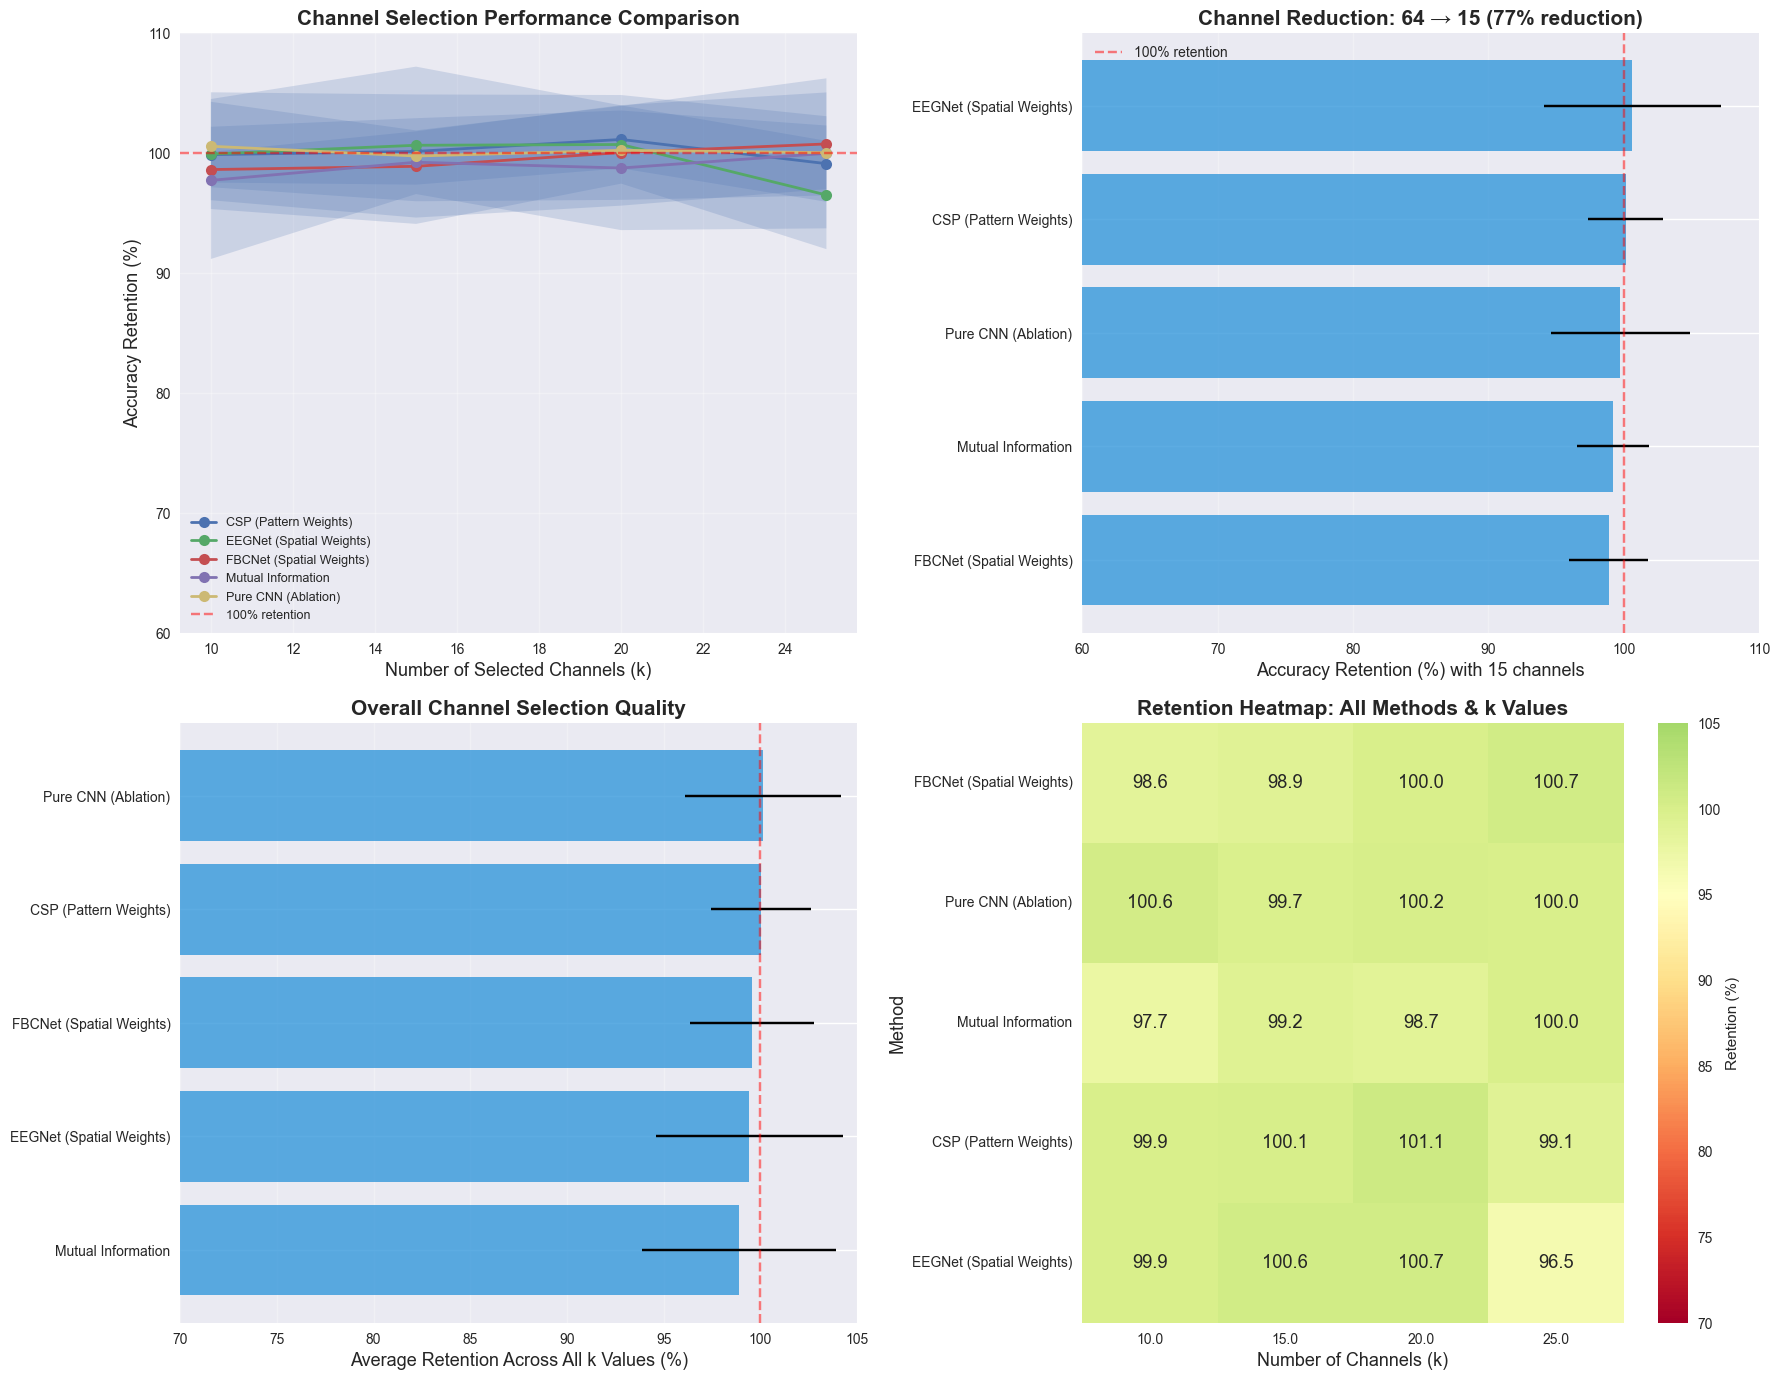


Visualization saved to: results\channel_selection_comparison\channel_selection_comparison.png


In [43]:
if len(results_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # 1. Accuracy Retention vs Number of Channels
    for method in sorted(results_df['method'].unique()):
        method_data = results_df[results_df['method'] == method]
        retention_by_k = method_data.groupby('k')['retention'].agg(['mean', 'std']).reset_index()
        
        # Color EEG-ARNN methods in green
        if 'ARNN' in method:
            color = '#2ecc71' if 'AS' in method else '#27ae60'
            linestyle = '-' if 'AS' in method else '--'
            linewidth = 3
        else:
            color = None
            linestyle = '-'
            linewidth = 2
            
        axes[0, 0].plot(retention_by_k['k'], retention_by_k['mean'], marker='o', label=method, 
                       linewidth=linewidth, markersize=8, color=color, linestyle=linestyle)
        axes[0, 0].fill_between(retention_by_k['k'], 
                                retention_by_k['mean'] - retention_by_k['std'],
                                retention_by_k['mean'] + retention_by_k['std'],
                                alpha=0.2, color=color)
    
    axes[0, 0].set_xlabel('Number of Selected Channels (k)', fontsize=13)
    axes[0, 0].set_ylabel('Accuracy Retention (%)', fontsize=13)
    axes[0, 0].set_title('Channel Selection Performance Comparison', fontsize=15, fontweight='bold')
    axes[0, 0].axhline(100, color='red', linestyle='--', alpha=0.5, label='100% retention')
    axes[0, 0].legend(fontsize=9, loc='lower left')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim([60, 110])
    
    # 2. Retention at k=15 (best comparison point - 76% reduction)
    k_compare = 15
    if k_compare in results_df['k'].values:
        retention_at_k = results_df[results_df['k'] == k_compare].groupby('method')['retention'].agg(['mean', 'std']).reset_index()
        retention_at_k = retention_at_k.sort_values('mean', ascending=True)
        
        colors = ['#2ecc71' if 'AS' in m else '#27ae60' if 'ARNN' in m else '#3498db' for m in retention_at_k['method']]
        
        axes[0, 1].barh(retention_at_k['method'], retention_at_k['mean'], 
                       xerr=retention_at_k['std'], color=colors, alpha=0.8, capsize=5)
        axes[0, 1].set_xlabel(f'Accuracy Retention (%) with {k_compare} channels', fontsize=13)
        axes[0, 1].set_title(f'Channel Reduction: 64 → {k_compare} ({(1-k_compare/64)*100:.0f}% reduction)', 
                            fontsize=15, fontweight='bold')
        axes[0, 1].axvline(100, color='red', linestyle='--', alpha=0.5, label='100% retention')
        axes[0, 1].grid(True, alpha=0.3, axis='x')
        axes[0, 1].legend()
        axes[0, 1].set_xlim([60, 110])
    
    # 3. Average retention across all k values
    avg_retention_all_k = results_df.groupby('method')['retention'].agg(['mean', 'std']).reset_index()
    avg_retention_all_k = avg_retention_all_k.sort_values('mean', ascending=True)
    
    colors_avg = ['#2ecc71' if 'AS' in m else '#27ae60' if 'ARNN' in m else '#3498db' for m in avg_retention_all_k['method']]
    
    axes[1, 0].barh(avg_retention_all_k['method'], avg_retention_all_k['mean'], 
                   xerr=avg_retention_all_k['std'], color=colors_avg, alpha=0.8, capsize=5)
    axes[1, 0].set_xlabel('Average Retention Across All k Values (%)', fontsize=13)
    axes[1, 0].set_title('Overall Channel Selection Quality', fontsize=15, fontweight='bold')
    axes[1, 0].axvline(100, color='red', linestyle='--', alpha=0.5)
    axes[1, 0].grid(True, alpha=0.3, axis='x')
    axes[1, 0].set_xlim([70, 105])
    
    # 4. Heatmap of retention by method and k
    pivot_heatmap = results_df.pivot_table(index='method', columns='k', values='retention', aggfunc='mean')
    pivot_heatmap = pivot_heatmap.sort_values(by=pivot_heatmap.columns[-1], ascending=False)
    
    import seaborn as sns
    sns.heatmap(pivot_heatmap, annot=True, fmt='.1f', cmap='RdYlGn', center=95, 
                vmin=70, vmax=105, ax=axes[1, 1], cbar_kws={'label': 'Retention (%)'})
    axes[1, 1].set_xlabel('Number of Channels (k)', fontsize=13)
    axes[1, 1].set_ylabel('Method', fontsize=13)
    axes[1, 1].set_title('Retention Heatmap: All Methods & k Values', fontsize=15, fontweight='bold')
    
    plt.tight_layout()
    fig_path = CONFIG['output_dir'] / 'channel_selection_comparison.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nVisualization saved to: {fig_path}")
else:
    print("No results to visualize.")